>> Created new eval cache.
[CV] kernel=rbf, C=56.5926, gamma=0.0087244 -> CV Acc=0.8451
[CV] kernel=rbf, C=0.0197567, gamma=2.00692 -> CV Acc=0.8057
[CACHE] kernel=rbf, C=56.5926, gamma=0.0087244 -> CV Acc=0.8451
[CV] kernel=rbf, C=0.405542, gamma=0.34616 -> CV Acc=0.8340
[CACHE] kernel=rbf, C=56.5926, gamma=0.0087244 -> CV Acc=0.8451
[CV] kernel=rbf, C=2.55888, gamma=0.147296 -> CV Acc=0.8439
[CACHE] kernel=rbf, C=56.5926, gamma=0.0087244 -> CV Acc=0.8451
[CV] kernel=rbf, C=1158.48, gamma=0.0524385 -> CV Acc=0.8448
[CACHE] kernel=rbf, C=56.5926, gamma=0.0087244 -> CV Acc=0.8451
[CV] kernel=rbf, C=1158.87, gamma=0.0011861 -> CV Acc=0.8500
[CACHE] kernel=rbf, C=1158.87, gamma=0.0011861 -> CV Acc=0.8500
[CV] kernel=rbf, C=4482.27, gamma=1.00376 -> CV Acc=0.8455
[CACHE] kernel=rbf, C=1158.87, gamma=0.0011861 -> CV Acc=0.8500
[CV] kernel=rbf, C=0.0635248, gamma=0.0268428 -> CV Acc=0.2890
[CACHE] kernel=rbf, C=1158.87, gamma=0.0011861 -> CV Acc=0.8500
[CV] kernel=rbf, C=2.47349, gamma=0.010

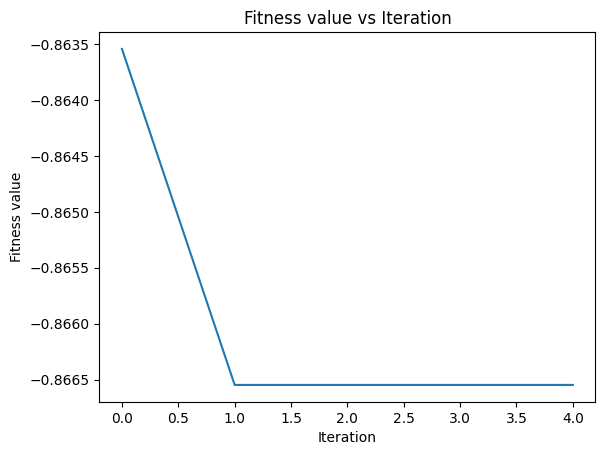


==== BEST PARAMETERS FOUND ====
Kernel = rbf
log10(C) = 0.4080
log10(gamma) = 0.6679
C = 2.55888
gamma = 4.65463
>> Final Test Accuracy: 0.8712
>> Done. Evaluated 157 combinations. Results saved.


In [ ]:
# 1) Imports
import os
import joblib
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from cso import CSO  # Ensure you have this installed properly

# 2) Seed
np.random.seed(42)

# 3) Load PhoBERT embeddings & labels
X_train = np.load('models/svm/X_train_emb.npy')
y_train = np.load('models/svm/y_train.npy')
X_test = np.load('models/svm/X_test_emb.npy')
y_test = np.load('models/svm/y_test.npy')


# kernels = ['linear', 'rbf']       # Kernel options

# 4) CSO parameter bounds
# recommend C in [2^-5, 2^15] and gamma in [2^-15, 2^3]
bounds = [
    (-2, 4),   # log10(C): C ∈ [0.01, 10000]
    (-4, 1)    # log10(gamma): gamma ∈ [0.0001, 10]
]

# 5) Cross-validation config
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 6) Evaluation cache
CACHE_PATH = 'models/svm/svm_cso_eval_cache_2.joblib'
eval_cache = {}

if os.path.exists(CACHE_PATH):
    eval_cache = joblib.load(CACHE_PATH)
    print(f">> Loaded eval cache with {len(eval_cache)} entries.")
else:
    os.makedirs(os.path.dirname(CACHE_PATH), exist_ok=True)
    print(">> Created new eval cache.")


# 7) Decode parameter vector from CSO
def _decode_params(X):
    """
    Decode CSO parameter vector to SVM hyperparameters.
    X[0]: log10(C)
    X[1]: log10(gamma)
    """
    log_C = X[0]
    log_gamma = X[1]
    
    C = 10 ** log_C
    gamma = 10 ** log_gamma
    kernel = 'rbf'  # Fixed kernel
    
    return log_C, log_gamma, C, gamma, kernel

# 8) Fitness function for CSO (minimize -accuracy)
def svm_fitness(X):
    log_C, log_gamma, C, gamma, kernel = _decode_params(X)
    cache_key = (kernel, C, gamma)

    if cache_key in eval_cache:
        acc = eval_cache[cache_key]
        print(f"[CACHE] kernel={kernel}, C={C:.6g}, gamma={gamma:.6g} -> CV Acc={acc:.4f}")
        return -acc

    clf = SVC(C=C, kernel=kernel, gamma=gamma, random_state=42)

    try:
        scores = cross_val_score(clf, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
        acc = float(scores.mean())
        eval_cache[cache_key] = acc
        print(f"[CV] kernel={kernel}, C={C:.6g}, gamma={gamma:.6g} -> CV Acc={acc:.4f}")
        joblib.dump(eval_cache, CACHE_PATH)
    except Exception as e:
        print(f"[ERROR] Evaluation failed: {e}")
        acc = 0.0
        eval_cache[cache_key] = acc
        joblib.dump(eval_cache, CACHE_PATH)

    return -acc

# 9) Run CSO optimizer
cso = CSO(
    fitness=svm_fitness,
    P=20,
    n=2,          # Dimensionality: log10(C), log10(gamma)
    bound=bounds,
    Tmax=5,
    verbose=True,
    plot=True,
    min=True
)

cso.execute()

# 10) Decode best solution
best = cso.best
log_C_best, log_gamma_best, C_best, gamma_best, kernel_best = _decode_params(best)

print("\n==== BEST PARAMETERS FOUND ====")
print(f"Kernel = {kernel_best}")
print(f"log10(C) = {log_C_best:.4f}")
print(f"log10(gamma) = {log_gamma_best:.4f}")
print(f"C = {C_best:.6g}")
print(f"gamma = {gamma_best:.6g}")

# 12) Train final model with best params
clf_opt = SVC(C=C_best, gamma=gamma_best, kernel=kernel_best, random_state=42)
clf_opt.fit(X_train, y_train)

# 13) Evaluate on test set
y_pred_opt = clf_opt.predict(X_test)
acc_opt = accuracy_score(y_test, y_pred_opt)
print(f">> Final Test Accuracy: {acc_opt:.4f}")

# 14) Save final model
joblib.dump(clf_opt, 'models/svm/svm_cso_optimized_2.joblib')

# 15) Save results
results = {
    'best_vector': best,  # vector trong không gian CSO (logC, logGamma)
    'best_kernel': kernel_best,
    'best_C': C_best,
    'best_gamma': gamma_best,
    'log10_C': log_C_best,
    'log10_gamma': log_gamma_best,
    'cv_strategy': '5-fold StratifiedKFold, random_state=42',
    'test_accuracy': float(acc_opt),
}

joblib.dump(results, 'models/svm/svm_cso_results_2.joblib')

print(f">> Done. Evaluated {len(eval_cache)} combinations. Results saved.")

Accuracy: 0.8712361331220285
Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       757
           1       0.84      0.88      0.86       757
           2       0.83      0.85      0.84       757
           3       0.83      0.82      0.83       758
           4       0.93      0.93      0.93       757
           5       0.79      0.76      0.77       757
           6       0.86      0.87      0.86       758
           7       0.98      0.98      0.98       757
           8       0.86      0.80      0.83       757
           9       0.93      0.95      0.94       757

    accuracy                           0.87      7572
   macro avg       0.87      0.87      0.87      7572
weighted avg       0.87      0.87      0.87      7572



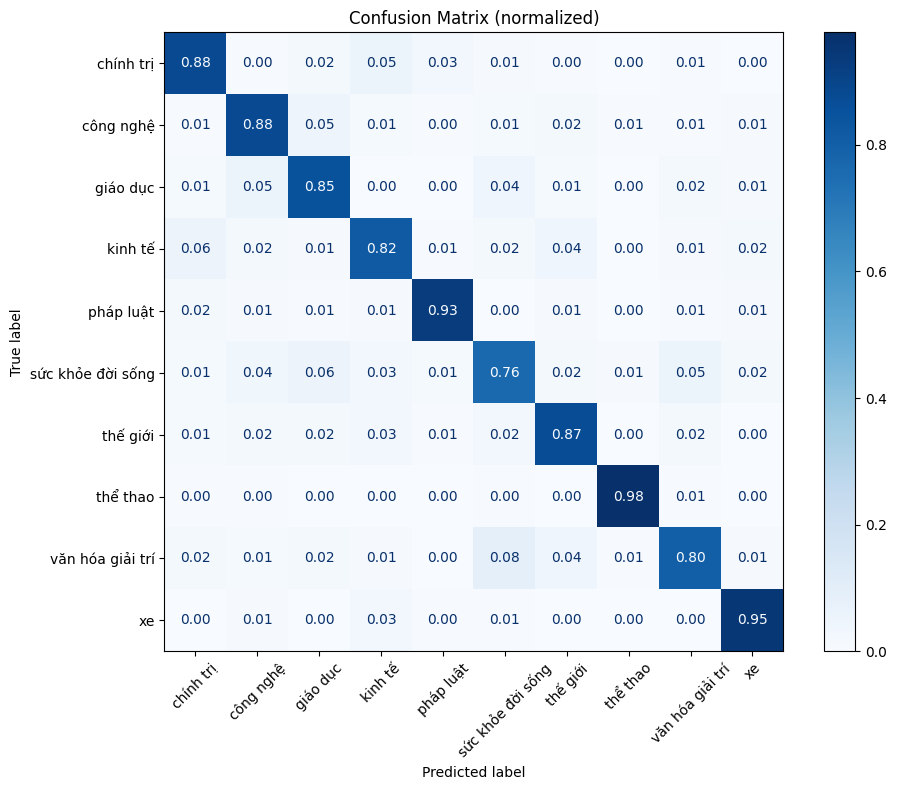

d:\DoAnTotNghiep\Document_Classification_With_Cuckoo_Search\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


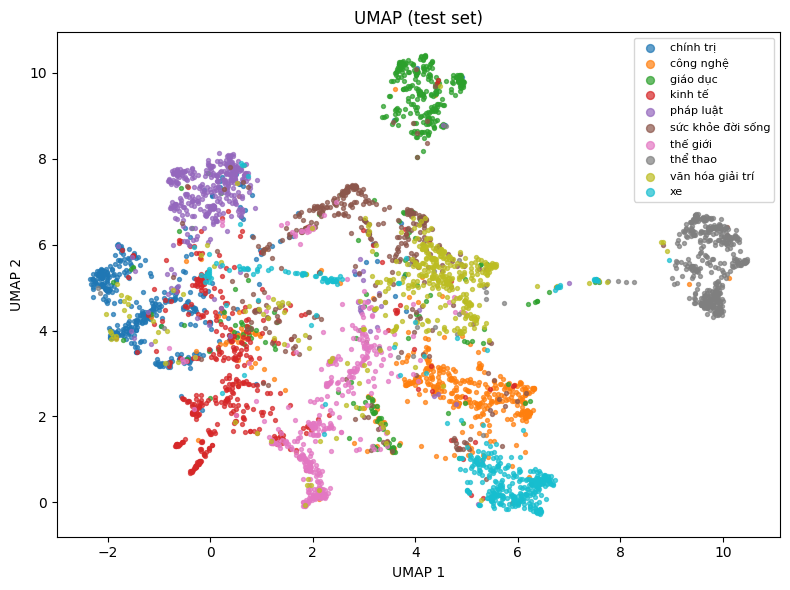

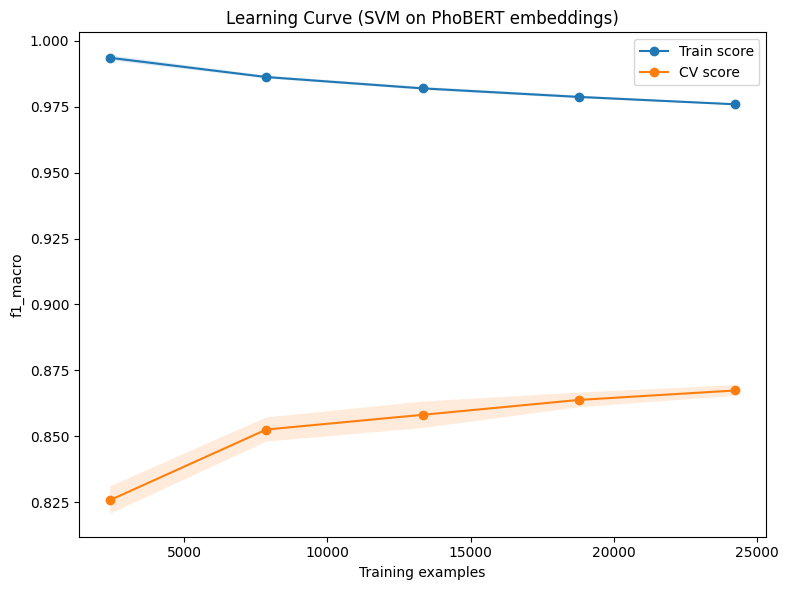

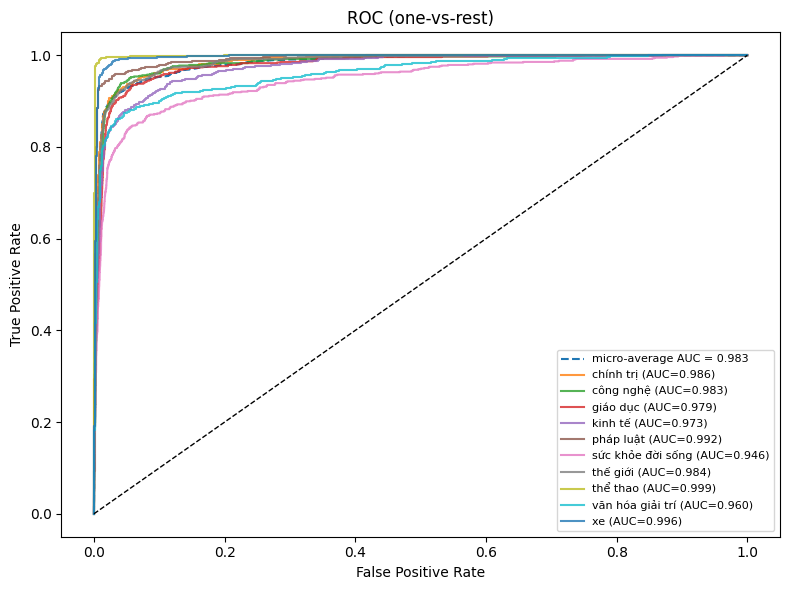

In [5]:
import numpy as np
import joblib
from sklearn.metrics import classification_report, accuracy_score
from phobert_svm_pipeline import (  
    plot_roc_multiclass,
    evaluate_confusion_matrix, plot_umap_embeddings, plot_learning_curve_svm
)

X_train = np.load('models/svm/X_train_emb.npy')
y_train = np.load('models/svm/y_train.npy')
X_test = np.load('models/svm/X_test_emb.npy')
y_test = np.load('models/svm/y_test.npy')
le = joblib.load('models/svm/label_encoder.joblib')

# Load model
with open("models/svm/svm_cso_optimized_2.joblib", "rb") as f:
    clf = joblib.load(f)

# Giả sử bạn có X_test và y_test
# Nếu chưa có, bạn cần nạp lại X_test, y_test đúng định dạng đã train

# Dự đoán
y_pred = clf.predict(X_test)

# In các chỉ số đánh giá
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# 1) Confusion matrix (dùng EMBEDDING đã lưu -> không embed lại)
evaluate_confusion_matrix(
    clf, le,
    X_emb=X_test,
    y_true_labels=y_test,
    normalize=True
)

# 2) UMAP (dùng EMBEDDING đã lưu)
# Lưu ý: cần cài umap-learn trước khi chạy:  pip install umap-learn
plot_umap_embeddings(
    X_emb=X_test,
    y_int=y_test,
    le=le,
    title="UMAP (test set)"
)

# 3) Learning curve (trên EMBEDDING train đã lưu)
plot_learning_curve_svm(
    clf,
    X_emb=X_train,
    y_labels=y_train,
    scoring="f1_macro"
)

# 4) ROC (dùng EMBEDDING sẵn)
plot_roc_multiclass(clf, le, X_emb=X_test, y_true_labels=y_test)